In [ ]:
!pip install anytree
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from anytree import Node
from anytree import PreOrderIter
from graphviz import Digraph

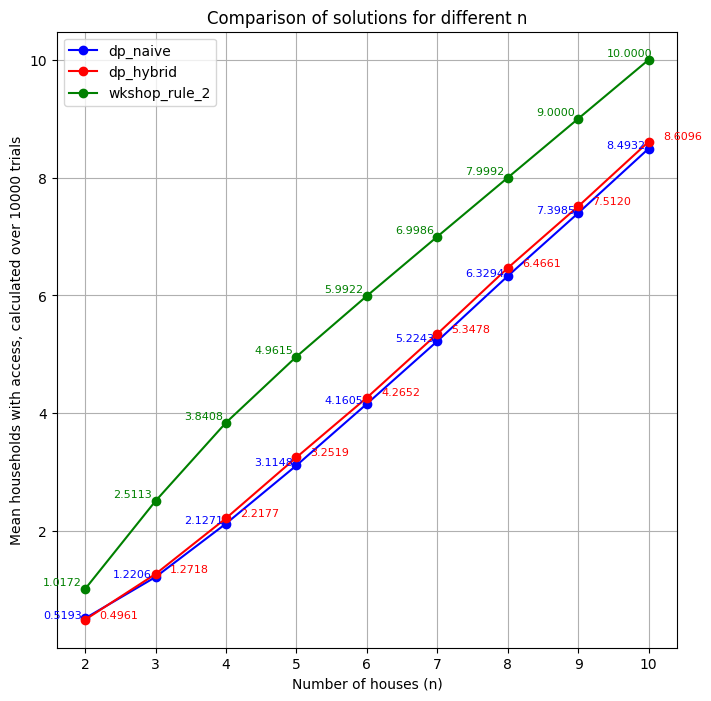

In [2]:
def dp_naive(n):
    table = np.empty((101, n))
    table[:] = np.nan

    table[100, 0] = int(100 / n)
    table[1:100, 0] = np.nan
    table[0, 1:] = 0
    table[1:, n - 1] = np.arange(1, 101)

    for house_index in range(1, n - 1):
        houses_left = n - house_index
        r_values = np.arange(1, 101)
        threshold = 100 / houses_left

        mask = r_values <= threshold
        table[1:, house_index] = np.where(
            mask, r_values, r_values // houses_left)

    return table


def dp_hybrid(n, h_initial=0.8, h_threshold=0.6):
    table = np.empty((101, n))
    table[:] = np.nan

    # h_initial grid search
    h_initial_search_start = int(100 / n)
    h_initial_search_end = int(100)
    hybrid_initial = int(h_initial * h_initial_search_start +
                         (1 - h_initial) * h_initial_search_end)

    # h_threshold grid search
    h_threshold_search_start = 50
    h_threshold_search_end = 200
    hybrid_threshold = int(h_threshold * h_threshold_search_start +
                           (1 - h_threshold) * h_threshold_search_end)

    table[100, 0] = hybrid_initial
    table[1:100, 0] = np.nan
    table[0, 1:] = 0
    table[1:, n - 1] = np.arange(1, 101)

    # Rest of the table
    for house_index in range(1, n - 1):
        houses_left = n - house_index
        r_values = np.arange(1, 101)
        threshold = hybrid_threshold / houses_left

        mask = r_values <= threshold
        table[1:, house_index] = np.where(
            mask, r_values, r_values // houses_left)

    return table


def evaluate_dp(table, n_trials=10000, seed_value=None):

    # Setting seed so all techniques are evaluated on the same random values.
    if seed_value is not None:
        np.random.seed(seed_value)

    total_households_with_access = []
    random_values = np.round(np.random.uniform(
        0, 100, (n_trials, len(table[0])))).astype(int)

    for trial_values in random_values:
        houses_convinced = 0
        amount_remaining = 100

        for index, value in enumerate(trial_values):
            if table[int(amount_remaining), index] <= value:
                houses_convinced += 1
                amount_remaining -= table[int(amount_remaining), index]

        if amount_remaining == 0:
            total_households_with_access.append(houses_convinced)
        else:
            total_households_with_access.append(0)

    return np.mean(total_households_with_access)


def evaluate_wkshop_rules(n_households, strategy, n_trials=10000, seed_value=None):
    # Setting seed so all techniques are evaluated on the same random values.
    if seed_value is not None:
        np.random.seed(seed_value)

    total_households_with_access = []
    random_values = np.round(np.random.uniform(
        0, 100, (n_trials, n_households))).astype(int)

    for trial_values in random_values:

        if strategy.endswith('2'):
            funds_collected = sum(trial_values)
            if funds_collected >= 100:
                total_households_with_access.append(n_households)
            else:
                total_households_with_access.append(0)

    return np.mean(total_households_with_access)


def evaluate_and_plot(solutions, min_n, max_n, n_trials=10000, step=1, seed_value=None):
    n_values = list(range(min_n, max_n + 1, step))
    colors = ['blue', 'red', 'green', 'magenta', 'cyan']

    plt.figure(figsize=(8, 8))
    for i, technique in enumerate(solutions):
        mean_households_with_access = []
        for n in n_values:
            # Checking if workshop rule or dp soln.
            if not (isinstance(technique, str)):
                table = technique(n)
                mean_access = evaluate_dp(table, n_trials, seed_value)
                mean_households_with_access.append(mean_access)
                label = technique.__name__
            else:
                mean_access = evaluate_wkshop_rules(
                    n, technique, n_trials, seed_value)
                mean_households_with_access.append(mean_access)
                label = technique

            # Add text label for the actual value
            x_offset = -0.6 if i % 2 == 0 else 0.2
            y_offset = i * 0.03
            plt.text(n + x_offset, mean_access + y_offset,
                     f'{mean_access:.4f}', color=colors[i], fontsize=8)

        plt.plot(n_values, mean_households_with_access,
                 marker='o', color=colors[i], label=label)

    plt.title('Comparison of solutions for different n')
    plt.xlabel('Number of houses (n)')
    plt.ylabel(
        f'Mean households with access, calculated over {n_trials} trials')

    plt.legend()
    plt.grid()


dp_solutions = [dp_naive, dp_hybrid, "wkshop_rule_2"]
evaluate_and_plot(dp_solutions, 2, 10, step=1, seed_value=6)

# # Generate heatmap
# table = dp_hybrid(3)
# plt.figure(figsize=(10, 20))
# ax = sns.heatmap(table, cmap="YlGnBu", annot=True, fmt=".0f", cbar_kws={'label': 'Money to Ask'})
# plt.show()


In [3]:
# Simple grid search to find optimal hyperparamters.
def find_optimal_h(min_n, max_n, step, h_values, seed_value=None):
    best_w = 0
    best_performance = 0

    for h in h_values:
        mean_households_with_access = []
        for n in range(min_n, max_n + 1, step):
            table = dp_hybrid(n, h_initial=h) # Finding optimal value for h_initial
            mean_access = evaluate_dp(table, seed_value=seed_value)
            mean_households_with_access.append(mean_access)
        
        current_performance = np.mean(mean_households_with_access)
        if current_performance > best_performance:
            best_performance = current_performance
            best_h = h
    
    return best_h, best_performance


# Getting candidate values between 0 and 1
h_values = np.linspace(0, 1, 50)
# Optimising for below n range
min_n, max_n, step = 2, 15, 1
best_w, best_performance = find_optimal_h(min_n, max_n, step, h_values)

print(f"Best weight parameter w: {best_w}")
print(f"Best performance: {best_performance}")


Best weight parameter w: 0.7755102040816326
Best performance: 7.022100000000001


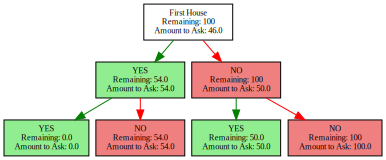

In [4]:
def visualize_tree(binary_tree):
    # Directed graph
    dot = Digraph()
    dot.attr('graph', size='15.15', bgcolor='white', ranksep='0.3', nodesep='0.1')
    
    # Iterating through all nodes
    for node in PreOrderIter(binary_tree):
        house_index, remaining_amount, houses_convinced, decision, amount_to_ask = node.name
        node_label = f"{decision}\nRemaining: {remaining_amount}\nAmount to Ask: {amount_to_ask}"
        
        # Node colour settings
        if decision == 'YES':
          node_color = 'lightgreen'  
        elif decision == 'NO': 
          node_color = 'lightcoral'
        else:
          node_color = 'white'
        
        # Adding node
        dot.node(str(id(node)), label=node_label, shape='rect', style='filled', fillcolor=node_color, fontsize='8.5')

        # Adding edges
        if node.parent is not None:
            edge_color = 'green' if decision == 'YES' else 'red'
            dot.edge(str(id(node.parent)), str(id(node)), color=edge_color)

    dot.render('aa_1_tree', format='png')
    return dot


def build_tree(house_index, remaining_amount, houses_convinced, table, decision):
    if house_index >= table.shape[1] or remaining_amount <= 0:
        amount_to_ask = None
        if house_index > 0:
            amount_to_ask = table[int(remaining_amount), house_index - 1]
        return Node((house_index, remaining_amount, houses_convinced, decision, amount_to_ask))

    amount_to_ask = table[int(remaining_amount), house_index - 1]
    node = Node((house_index, remaining_amount, houses_convinced, decision, amount_to_ask))

    # YES cases
    new_remaining = remaining_amount - amount_to_ask
    new_houses_convinced = houses_convinced + 1
    yes_child = build_tree(house_index + 1, new_remaining, new_houses_convinced, table, "YES")
    yes_child.parent = node
    
    # NO cases
    no_child = build_tree(house_index + 1, remaining_amount, houses_convinced, table, "NO")
    no_child.parent = node

    return node


def generate_tree(table):
    root = build_tree(1, 100, 0, table, "First House")
    return root

n = 3
table = dp_hybrid(n)
binary_tree = generate_tree(table)
visualize_tree(binary_tree)